In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append('../../')
print(sys.path)
import torch
import numpy as np
from tools.libaudio.utils import load
import IPython.display as ipd
from tools.libaudio.feature import melspectrogram
from tools.libaudio.display import show_spec, show_mel
from mlutils.utils import plot, plots
from models.mlmodeldic import best_model_path_and_settings
from tts.Alternative.neuravoice import Vocoder
from tts.Alternative.dataset import NeuraVoiceDataset
from torch.utils.data import DataLoader

['/var/Sources/experiments/core/tts/Alternative', '/home/kaz/anaconda3/envs/core/lib/python37.zip', '/home/kaz/anaconda3/envs/core/lib/python3.7', '/home/kaz/anaconda3/envs/core/lib/python3.7/lib-dynload', '', '/home/kaz/.local/lib/python3.7/site-packages', '/home/kaz/anaconda3/envs/core/lib/python3.7/site-packages', '/home/kaz/anaconda3/envs/core/lib/python3.7/site-packages/Mako-1.0.7-py3.7.egg', '/home/kaz/anaconda3/envs/core/lib/python3.7/site-packages/IPython/extensions', '/home/kaz/.ipython', '../../']


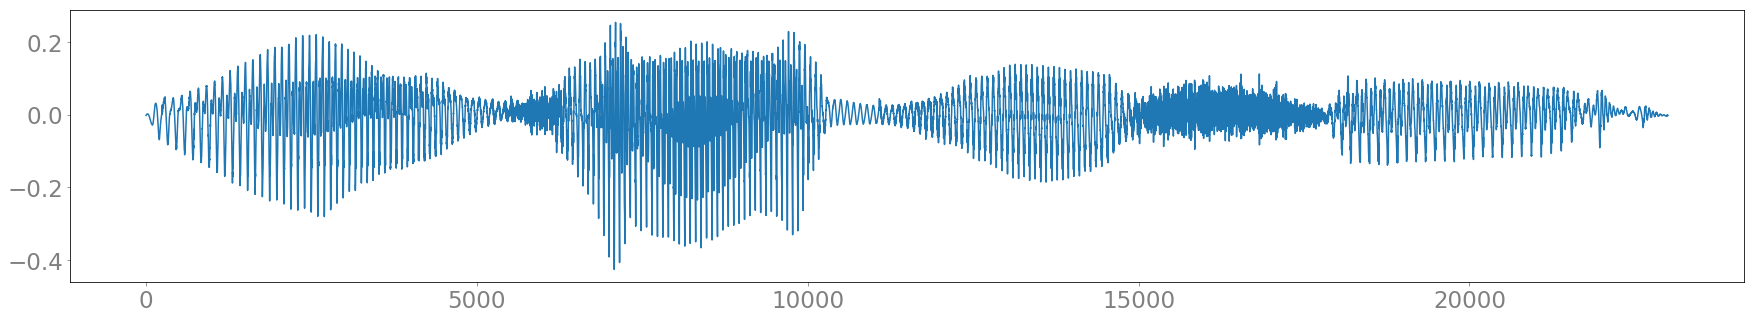

In [2]:
sample_index = 6
dataset = NeuraVoiceDataset()
wav = dataset[sample_index]['wav']
wav = wav[30000:53000]
plot(wav)

In [3]:
ipd.Audio(wav, rate=24000)

In [4]:
#text_005 = 'ケツアツハケンコウノバロメータートシテジュウヨウデアル'
text = 'ニュージャージーシュウ'

In [5]:
wav.shape

(23000,)

In [6]:
mel = melspectrogram(wav, sample_rate=24000, n_fft=2048, hop_length=300, power=2.0)

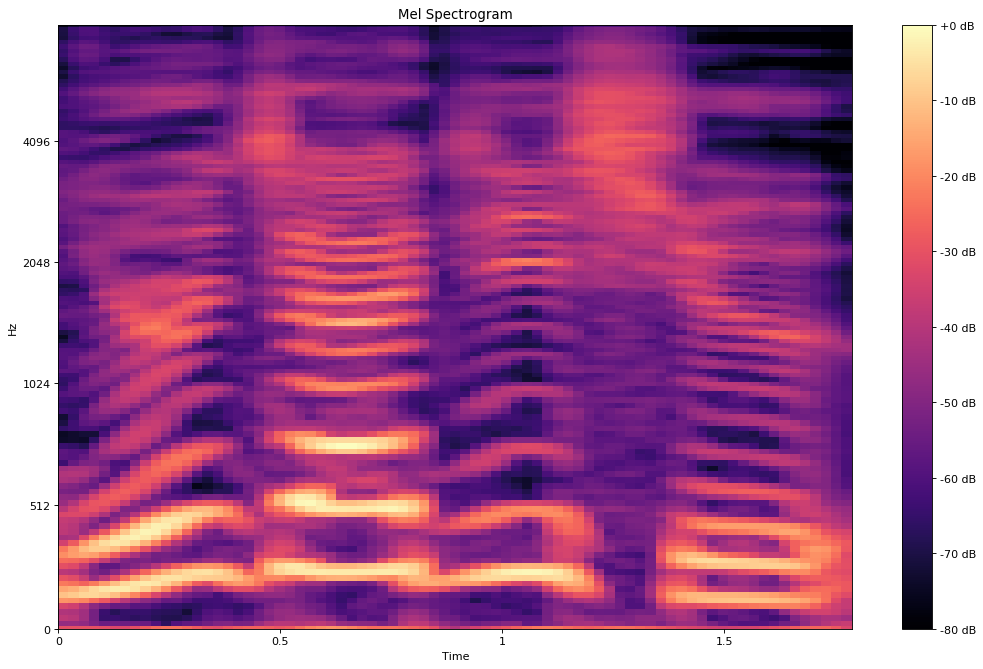

In [7]:
show_mel(mel)

In [8]:
mel = torch.Tensor(mel).unsqueeze(0)
mel.shape

torch.Size([1, 128, 77])

Upsample test

In [9]:
T = int(mel.shape[2] * 299.19)

In [10]:
mel_upsample = torch.nn.functional.interpolate(mel, T, mode='linear', align_corners=True)
mel_upsample, mel_upsample.shape

(tensor([[[1.5800e-01, 1.5804e-01, 1.5809e-01,  ..., 9.7240e-02,
           9.6600e-02, 9.5961e-02],
          [4.2968e-03, 4.2978e-03, 4.2987e-03,  ..., 4.0906e-02,
           4.0938e-02, 4.0971e-02],
          [2.6082e-02, 2.6058e-02, 2.6035e-02,  ..., 7.0469e-03,
           7.0344e-03, 7.0219e-03],
          ...,
          [1.7142e-05, 1.7313e-05, 1.7484e-05,  ..., 1.4828e-06,
           1.4832e-06, 1.4836e-06],
          [1.8299e-05, 1.8489e-05, 1.8679e-05,  ..., 4.1512e-06,
           4.1504e-06, 4.1495e-06],
          [3.6446e-06, 3.6672e-06, 3.6899e-06,  ..., 5.0000e-07,
           4.9990e-07, 4.9980e-07]]]), torch.Size([1, 128, 23037]))

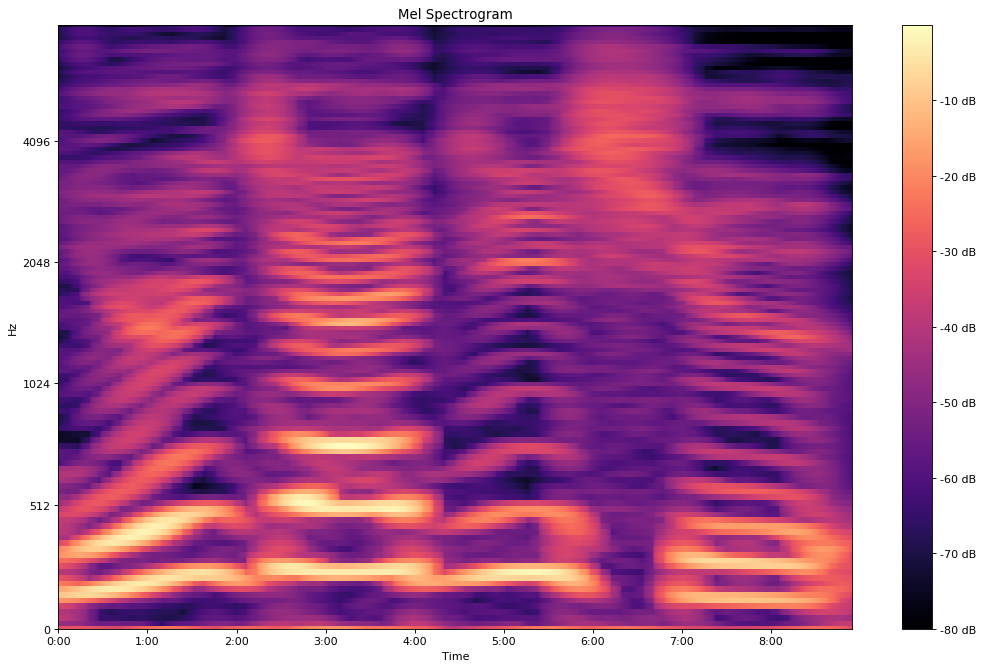

In [11]:
show_mel(mel_upsample.squeeze())

In [12]:
mel_upsample.transpose(1,2)[:, 0, :].shape

torch.Size([1, 128])

Genarate test

In [54]:
model_name = 'vocoder_512_16_0.0001'
model_name = 'vocoder_test'

In [55]:
batch_size=1
dataset = NeuraVoiceDataset(batch_size=batch_size)
loader = DataLoader(
    dataset, batch_size=batch_size, shuffle=False, collate_fn=dataset.collate_fn, drop_last=False, num_workers=1)

In [56]:
model_path, settings = best_model_path_and_settings(model_name, 'loss_ave', is_lower_better=True)
model_path, settings

('/diskB/6/out/models/vocoder/vocoder_test_512_bit9_epoch1000_lr0.0001_loss1-788_10',
 {'lr': 0.0001,
  'n_epoch': 1000,
  'seqlen': 5000,
  'stride': 500,
  'hidden_size': 512,
  'bit': 9,
  'sample_rate': 24000,
  'ax_size': 0})

In [57]:
device = 'cuda:1'

In [58]:
model = Vocoder.init_from_settings(settings, model_path, device)

Trainable Parameters: 3.744 million


In [59]:
#model.cpu()
#model.__device__ = 'cpu'
#model.to_device('cpu')
#
#for n, p in model.named_parameters():
#    print(n, p.data)

In [60]:
%time
generated = model.generate(mel, parallel=10)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 10.7 µs
generate 10010/23037, batch 10, Speed: 4836.18 samples/sec, x_realtime: 0.202
generate 20010/23037, batch 10, Speed: 4750.26 samples/sec, x_realtime: 0.198


In [61]:
generated

array([0., 0., 0., ..., 0., 0., 0.])

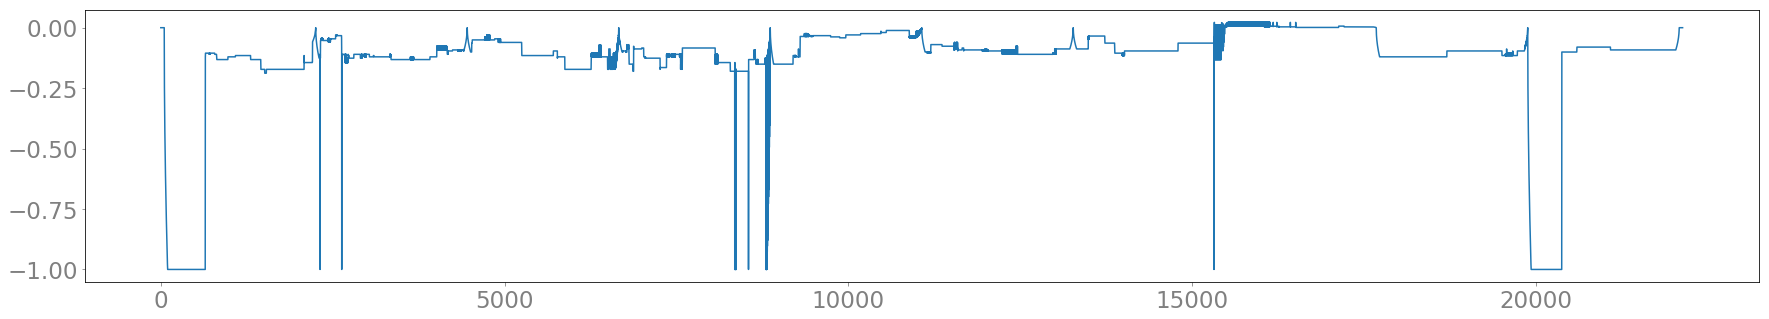

In [66]:
plot(generated)

Ground Truth

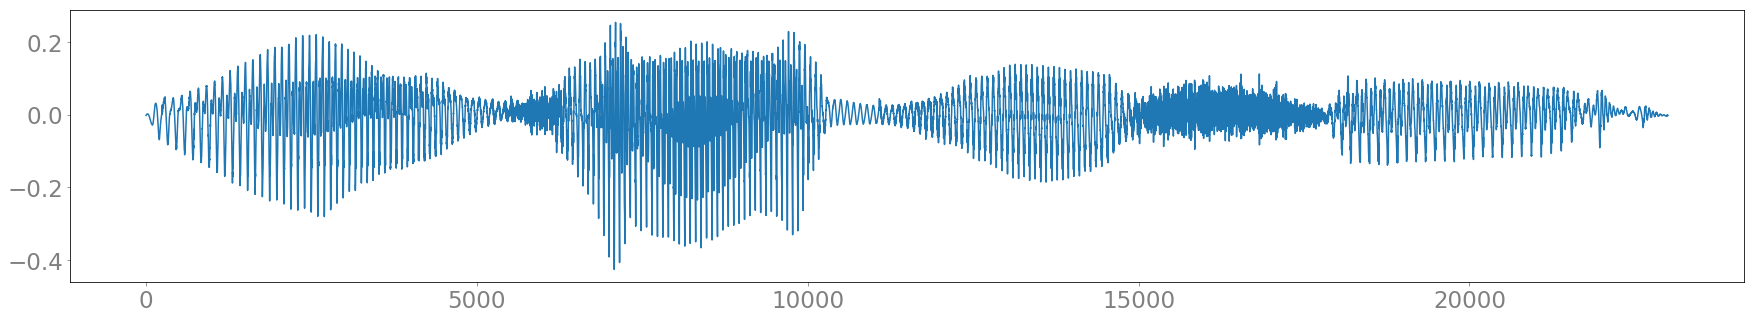

In [22]:
plot(wav)